## SpatialDE

The key features of this method are

* Unsupervised - No need to define spatial regions
* Non-parametric and non-linear expression patterns
* Automatic histology based on spatially coexpressed genes

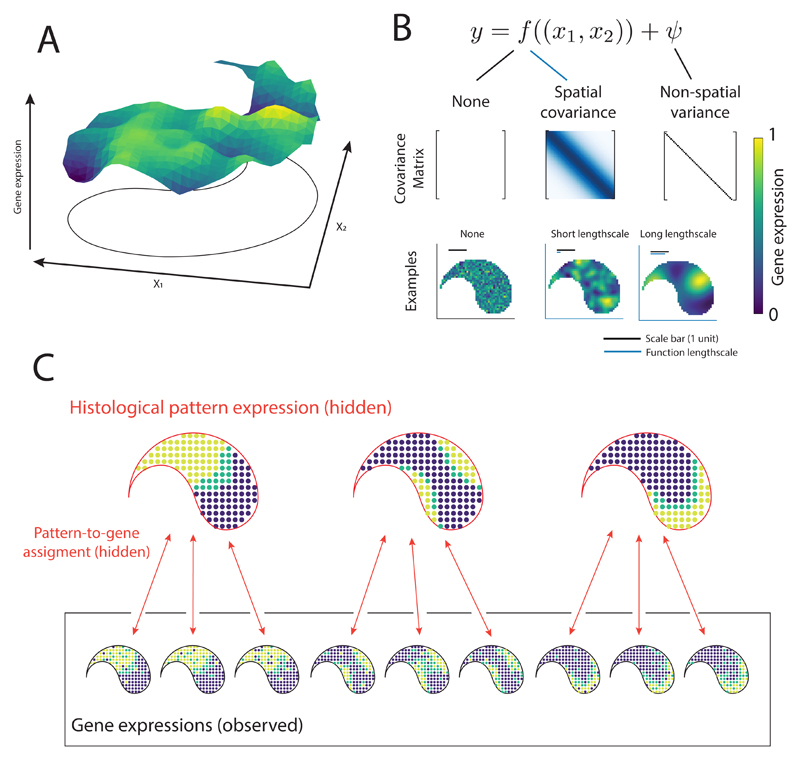

(A) In spatial gene expression studies, expression levels are measured as a function of spatial coordinates of cells or samples. SpatialDE defines spatial dependence for a given gene using a non-parametric regression model, testing whether gene expression levels at different locations co-vary in a manner that depends on their relative location, and thus are spatially variable. 

(B) SpatialDE partitions expression variation into a spatial component (using functional dependencies f(x1, x2)), characterized by spatial covariance, and independent observation noise (ψ). Representative simulated expression patterns are plotted below the corresponding covariance matrices for the null model (None) and the alternative model (Spatial covariance) with different lengthscales. 

(C) Automatic expression histology uses spatial clustering to model the expression levels of spatially variable genes using a set of unobserved tissue structure patterns. Both the underlying patterns and the gene-pattern assignments are learned from data.

In [1]:
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics

import NaiveDE
import SpatialDE

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Loading data
df = pd.read_csv('/vast/palmer/scratch/fan/my393/BENG469/L7/01.demo_data/GSM4189611_50t.tsv', index_col=0, delimiter="\t")

In [3]:
# Filter practically unobserved genes
df = df.T[df.sum(0) >= 3].T

In [4]:
print(df.shape)

(902, 18276)


In [5]:
df.iloc[:5, :5]

,Gm37180,Gm37686,Gm37329,Gm38148,Xkr4
10x28,0.0,0.0,0.0,0.0,0.0
10x29,0.0,0.0,0.0,0.0,0.0
10x30,0.0,0.0,0.0,0.0,0.0
10x31,0.0,0.0,0.0,0.0,0.0
10x32,0.0,0.0,0.0,0.0,0.0


In [6]:
# Get coordinates

def get_coords(index):
    coords = pd.DataFrame(index=index)
    coords['x'] = index.str.split('x').str.get(0).map(float)
    coords['y'] = index.str.split('x').str.get(1).map(float)
    return coords

sample_info = get_coords(df.index)


# Get total_counts for every spot
sample_info['total_counts'] = df.sum(1)

sample_info = sample_info.query('total_counts > 5')
df = df.loc[sample_info.index]

In [7]:
sample_info.head(5)

,x,y,total_counts
10x28,10.0,28.0,13362.0
10x29,10.0,29.0,11427.0
10x30,10.0,30.0,16641.0
10x31,10.0,31.0,6603.0
10x32,10.0,32.0,4963.0


This method assumes normally distributed noise, but the data we are using is from expression counts, and empirically seems to follow a negative binomial distribution. We use technique by Anscombe to approximately transform the data to normal distributed noise.

Secondly, library size or sequencing depth of the spatial samples will bias the expression of every gene. We use linear regression to account for this effect before performing the spatial test.

In [8]:
dfm = NaiveDE.stabilize(df.T).T
res = NaiveDE.regress_out(sample_info, dfm.T, 'np.log(total_counts)').T

In [9]:
#just run the test on 1000 random genes, all ~20,000 genes will takes about 10 minutes.

res_expr = res.sample(n=1000, axis=1, random_state=1)
X = sample_info[['x', 'y']]

In [10]:
%%capture --no-display
#Perform Spatial DE test with default settings
results = SpatialDE.run(X, res_expr)

Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

The result will be a DataFrame with P-values and other relevant values for each gene.

The most important columns are
* g - The name of the gene
* pval - The P-value for spatial differential expression
* qval - Signifance after correcting for multiple testing
* l - length scale, A parameter indicating the distance scale a gene changes expression over

In [11]:
results.head()

,FSV,M,g,l,max_delta,max_ll,max_mu_hat,max_s2_t_hat,model,n,s2_FSV,s2_logdelta,time,BIC,max_ll_null,LLR,pval,qval
0,2.150754e-01,4,Gm7332,0.5,3.647198e+00,102.022937,-0.733522,1.131001e-01,SE,902,0.033647,1.197090e+00,0.002658,-176.827416,101.302561,0.720376,0.396021,0.811518
1,5.239992e-02,4,Diexf,0.5,1.807243e+01,-509.189887,-1.407239,1.102823e-01,SE,902,0.693096,2.260909e+02,0.002134,1045.598232,-509.271768,0.081881,0.774765,0.986713
2,6.343229e-01,4,Gjd2,0.5,5.761152e-01,1124.530748,-0.346931,5.915018e-02,SE,902,0.023270,4.908328e-01,0.001128,-2221.843038,1119.400370,5.130378,0.023511,0.149093
3,2.059835e-09,4,Dph2,0.5,4.851652e+08,-47.894633,-0.886921,1.755562e-09,SE,902,1.293770,2.207842e+17,0.001644,123.007725,-47.894911,0.000277,0.986712,0.986713
4,2.670609e-01,4,Tmco4,0.5,2.742708e+00,810.764902,-0.353975,3.162169e-02,SE,902,0.047727,1.326236e+00,0.001435,-1594.311347,809.690920,1.073982,0.300048,0.719539


In [12]:
results.sort_values('qval').head(20)[['g', 'l','pval','qval']]

,g,l,pval,qval
570,Hba-x,1.567483,0.000000e+00,0.000000e+00
595,Myl2,2.775360,0.000000e+00,0.000000e+00
584,Ttn,2.775360,0.000000e+00,0.000000e+00
612,Fut9,2.775360,0.000000e+00,0.000000e+00
904,Synpo2l,4.914008,0.000000e+00,0.000000e+00
598,Vcan,2.775360,0.000000e+00,0.000000e+00
576,Glra1,2.775360,0.000000e+00,0.000000e+00
567,Pou2f2,1.567483,0.000000e+00,0.000000e+00
580,Pax6,2.775360,0.000000e+00,0.000000e+00
610,Alx1,2.775360,0.000000e+00,0.000000e+00


In [13]:
%%capture --no-display

#Finally, we can classify the DE genes to interpetable DE classes using the `model_search` function.
#We apply the model search on filtered DE results, using a threshold of 0.05 for the Q-values.

de_results = results[(results.qval < 0.05)].copy()
ms_results = SpatialDE.model_search(X, res, de_results)

Models:   0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

In [14]:
#Save results and annotation in files for interactive plotting and interpretation

sample_info.to_csv('50t_sample_info.csv', sep ="\t")
results.to_csv('50t_final_results.csv', sep = "\t")
ms_results.to_csv('50t_MS_results.csv',sep="\t")

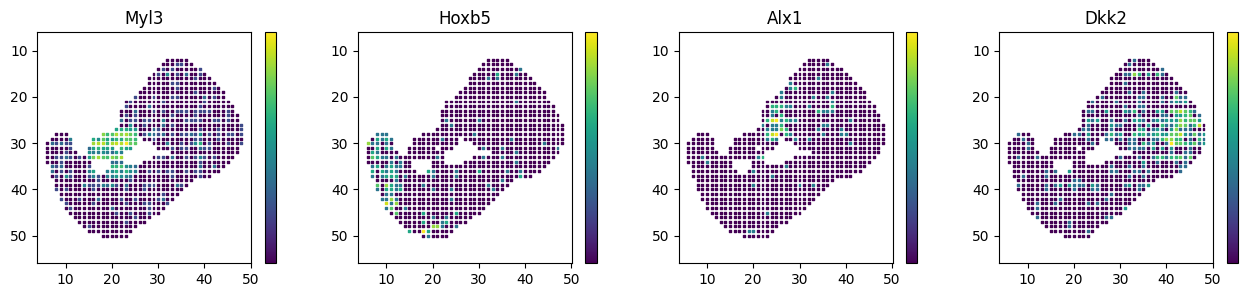

In [15]:
#visualize spatially differentially expressed genes 

figsize(20, 3)
for i, g in enumerate(['Myl3', 'Hoxb5', 'Alx1', 'Dkk2']):
    plt.subplot(1, 5, i + 1)
    plt.scatter(sample_info['x'], sample_info['y'], c=dfm[g], s=2, marker='s');
    plt.axis([0, 50, 0, 50])
    plt.xlim(0, 50) 
    plt.ylim(0, 50) 
    plt.xticks([0,10,20,30,40,50])
    plt.yticks([0,10,20,30,40,50])
    plt.axis('equal') 
    plt.title(g)
    plt.gca().invert_yaxis() 

    
    plt.colorbar(ticks=[]);

### Automatic expression histology

SpatialDE also implements 'automatic expression histology', a spatial gene-clustering approach that enables expression-based tissue histology.

To perform automatic expression histology (AEH), the genes should be filtered by SpatialDE significance. 

In [16]:
sign_results = results.query('qval < 0.05').copy()

In [17]:
#l, length scale, determines how rapidly the covariance decays as a function of distance.

sign_results['l'].value_counts()

4.914008     39
0.500000     29
2.775360     23
1.567483     10
8.700662      5
0.885292      3
15.405249     3
27.276283     1
Name: l, dtype: int64

In [18]:
statistics.mean(sign_results['l'])

3.5867754647192602

Here we see that the lengthscale on average is ~3.5, to use some extra spatial covariance, we put this paramater to l = 4.

In [19]:
# we can group spatially variable genes (SVGs) into spatial patterns using automatic expression histology (AEH).
histology_results, patterns = SpatialDE.spatial_patterns(X, res_expr, sign_results, 8, 4, verbosity=1)

/home/beng469_mgl52/.conda/envs/spatialde/lib/python3.7/site-packages/SpatialDE/base.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])


iter 0, ELBO: -4.66e+11
iter 1, ELBO: -2.30e+11, delta_ELBO: 2.36e+11
iter 2, ELBO: -2.30e+11, delta_ELBO: 1.47e+04
iter 3, ELBO: -2.30e+11, delta_ELBO: 1.28e+03
iter 4, ELBO: -2.30e+11, delta_ELBO: 3.14e+02
iter 5, ELBO: -2.30e+11, delta_ELBO: 1.39e+02
iter 6, ELBO: -2.30e+11, delta_ELBO: 8.03e+00
iter 7, ELBO: -2.30e+11, delta_ELBO: 4.91e+00
iter 8, ELBO: -2.30e+11, delta_ELBO: 2.39e+01
iter 9, ELBO: -2.30e+11, delta_ELBO: 1.07e+01
iter 10, ELBO: -2.30e+11, delta_ELBO: 2.95e+01
iter 11, ELBO: -2.30e+11, delta_ELBO: 1.40e+01
iter 12, ELBO: -2.30e+11, delta_ELBO: 1.38e+01
iter 13, ELBO: -2.30e+11, delta_ELBO: 2.01e+01
iter 14, ELBO: -2.30e+11, delta_ELBO: 3.91e+01
iter 15, ELBO: -2.30e+11, delta_ELBO: 3.07e+00
iter 16, ELBO: -2.30e+11, delta_ELBO: 2.33e-01
iter 17, ELBO: -2.30e+11, delta_ELBO: 1.43e-03
Converged on iter 17


In [20]:
histology_results.head()

,g,pattern,membership
42,Tfdp2,5,1.000000
45,B330016D10Rik,5,0.999945
52,Prrc2c,7,1.000000
99,Atic,7,1.000000
126,Tes,0,1.000000


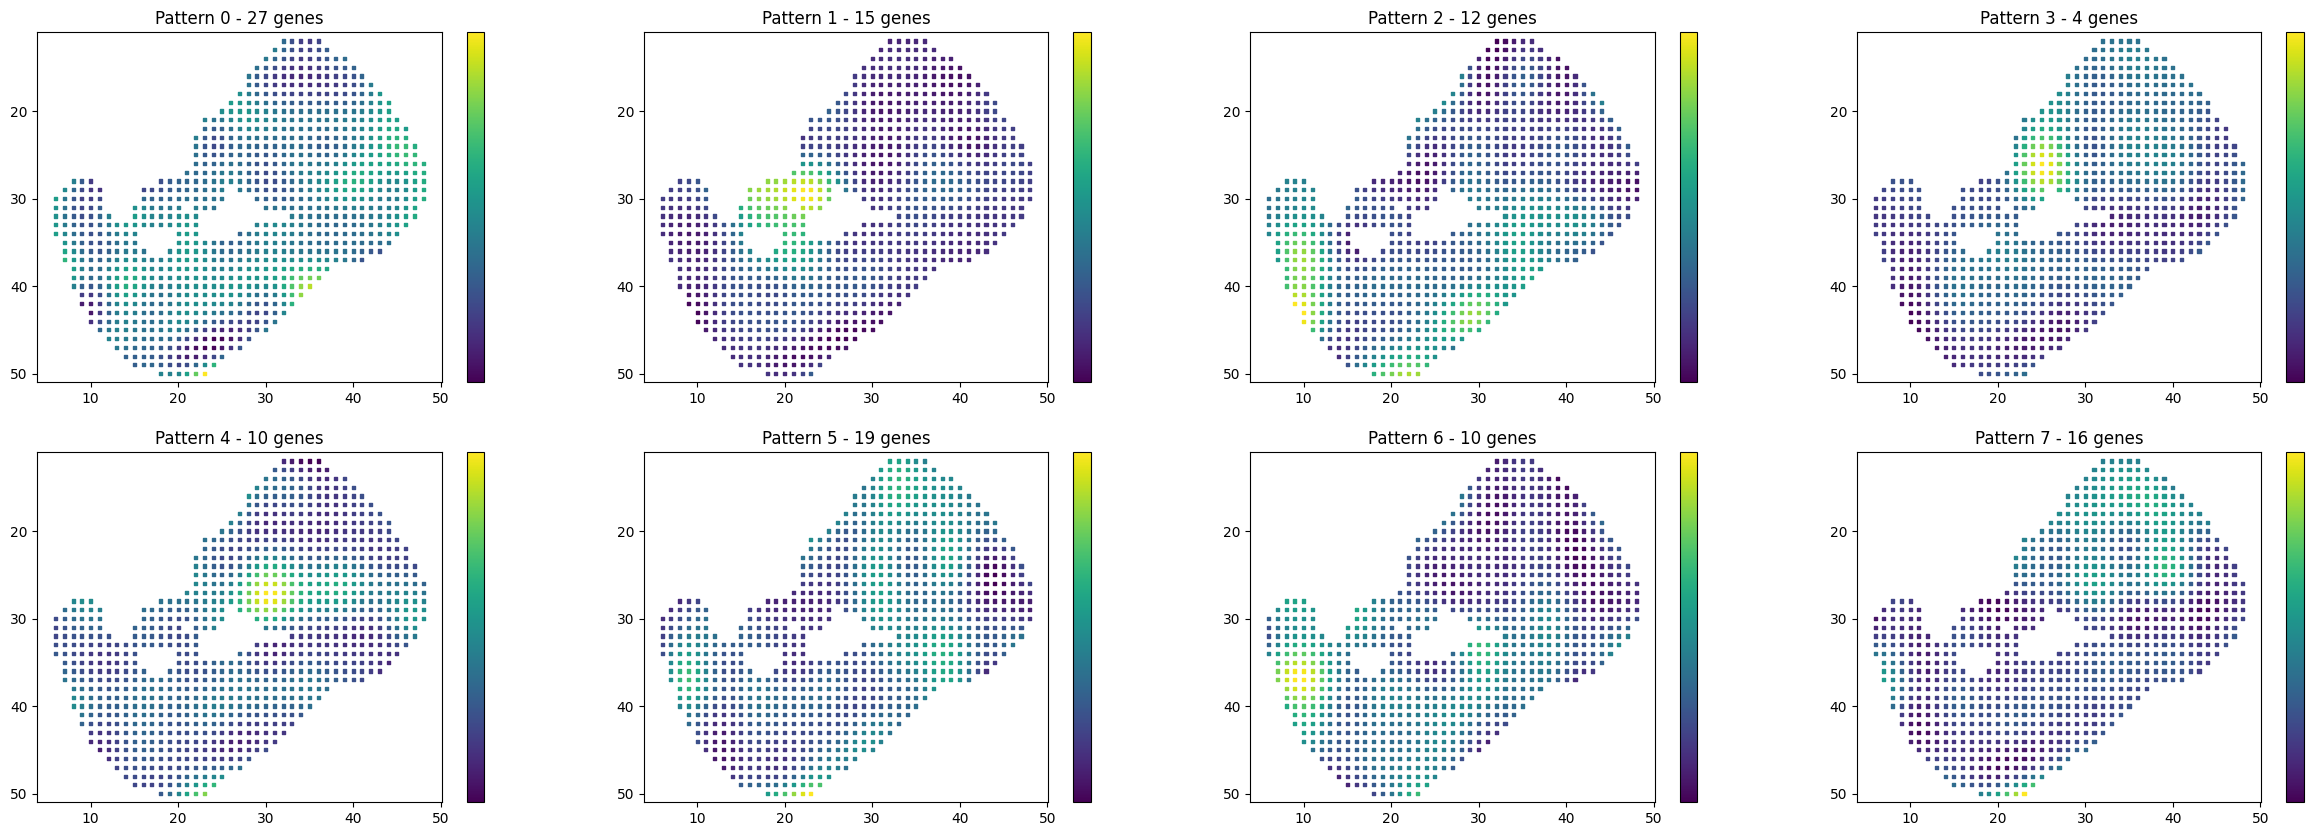

In [21]:
figsize(30, 10)
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.scatter(sample_info['x'], sample_info['y'], c=patterns[i], s=5, marker='s');
    plt.axis([0, 50, 0, 50])
    plt.xlim(0, 50) 
    plt.ylim(0, 50) 
    plt.xticks([0,10,20,30,40,50])
    plt.yticks([0,10,20,30,40,50])
    plt.axis('equal')
    plt.title('Pattern {} - {} genes'.format(i, histology_results.query('pattern == @i').shape[0] ))
    plt.gca().invert_yaxis()
    plt.colorbar(ticks=[]);

In [22]:
#To see what the coexpressed genes determining a histological pattern

for i in histology_results.sort_values('pattern').pattern.unique():
    
    print('Pattern {}'.format(i))
    print(', '.join(histology_results.query('pattern == @i').sort_values('membership')['g'].tolist()))
    print()

Pattern 0
Yy1, Fam111a, Eapp, Gm7729, Map3k4, Maf, Tgfbi, Tnc, Epm2aip1, Rbm26, Specc1l, Col14a1, Fras1, Bcl9, Capns1, Apod, Vcam1, Tes, Col8a1, Gm43072, Parm1, Plk2, Dcn, Elf1, Lama1, Hba-x, Epha7

Pattern 1
Frem2, Ppfibp2, Fbln2, Srpk3, Papss2, Clu, Svil, Kcnj5, Ltbp1, Ttn, Myl2, Vcan, Apobec2, Tbx5, Synpo2l

Pattern 2
Cblb, Klhl24, Ptov1, Frmpd3, Tsga10, Rnasel, C530008M17Rik, Epb41, Glra1, Rassf4, Pak1, Pou2f2

Pattern 3
Hmga2, Alx3, Alx1, Lima1

Pattern 4
Gm11353, Slc39a7, Gm15204, RP24-69E5.2, Tal2, Psmc3, 1110037F02Rik, B230219D22Rik, Prkca, Cep78

Pattern 5
Eif4g2, Ppp1r7, Foxj1, Zbtb18, Cdh7, B330016D10Rik, Efnb2, Mms22l, Ddx3x, Galnt16, Tspan13, Hpf1, Pax6, Pou3f3, Ptbp2, Ptges3, Hist1h4c, Tfdp2, Wnt7b

Pattern 6
Ttyh2, Bach2, Uqcrh, Bhlhe22, Cux2, Ednrb, Mfhas1, Zfp703, Mtus2, 1810041L15Rik

Pattern 7
Smarca5, Nup133, Ncapg2, Rps2, Nim1k, Prrc2c, Gm12918, Mpp6, Atic, Ddx21, Ssb, Suz12, Pcnt, Usp1, Nap1l1, Fut9

